In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import tabulate as tb

In [ ]:
CSV_PATH = "./../data/AAPL.csv"  
DATE_COL = "Date"            
TARGET_TYPE = "next_return"   # "next_close" or "next_return"
TRAIN_DATE_RANGE = ('2023-01-01', '2025-10-14')
TEST_DATE_RANGE = ('2025-10-15', '2025-10-20')
RANDOM_STATE = 42
EPOCHS = 300
BATCH_SIZE = 32

In [175]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------+----------+----------+----------+----------+-----------+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+-----------+-----------+-----------+------------+
|    | Date                |    Close |     High |      Low |     Open |    Volume |     rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |   BBL_20_2.0_2.0 |   BBM_20_2.0_2.0 |   BBU_20_2.0_2.0 |   BBB_20_2.0_2.0 |   BBP_20_2.0_2.0 |   ema_10 |   ema_20 |   ema_50 |       atr |   stoch_k |   stoch_d |    returns |
|----+---------------------+----------+----------+----------+----------+-----------+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+-----------+-----------+-----------+------------|
|  0 | 2000-03-14 00:00:0

In [176]:
df["next_close"] = df["Close"].shift(-1)
df["next_return"] = df["next_close"] / df["Close"] - 1.0

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["returns", "next_close", "next_return"]]
feature_cols = numeric_cols

df = df.dropna(subset=feature_cols + [TARGET_TYPE]).reset_index(drop=True)
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))

X = df[feature_cols].values
y = df[TARGET_TYPE].values
dates = df[DATE_COL].values

print(tb.tabulate(X[:5], headers=feature_cols, tablefmt='psql'))
print(tb.tabulate(y[:5].reshape(-1, 1), headers=[TARGET_TYPE], tablefmt='psql'))

+----+---------------------+----------+----------+----------+----------+-----------+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+-----------+-----------+-----------+------------+--------------+---------------+
|    | Date                |    Close |     High |      Low |     Open |    Volume |     rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |   BBL_20_2.0_2.0 |   BBM_20_2.0_2.0 |   BBU_20_2.0_2.0 |   BBB_20_2.0_2.0 |   BBP_20_2.0_2.0 |   ema_10 |   ema_20 |   ema_50 |       atr |   stoch_k |   stoch_d |    returns |   next_close |   next_return |
|----+---------------------+----------+----------+----------+----------+-----------+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+-----------+-

In [ ]:
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_test = dates[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#joblib.dump(scaler, "scaler.joblib")
print(f"Test dates from {dates_test[0]} to {dates_test[-1]}")

Test dates from 2024-07-08T00:00:00.000000000 to 2025-10-16T00:00:00.000000000


In [178]:
tf.random.set_seed(RANDOM_STATE)

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="linear") 
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,329 (75.50 KB)

 Trainable params: 19,329 (75.50 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0346 - mae: 0.1335 - val_loss: 0.0203 - val_mae: 0.1113
Epoch 2/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mae: 0.0990 - val_loss: 0.0088 - val_mae: 0.0773
Epoch 3/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - mae: 0.0853 - val_loss: 0.0062 - val_mae: 0.0584
Epoch 4/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - mae: 0.0736 - val_loss: 0.0086 - val_mae: 0.0778
Epoch 5/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - mae: 0.0651 - val_loss: 0.0031 - val_mae: 0.0447
Epoch 6/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0596 - val_loss: 0.0025 - val_mae: 0.0411
Epoch 7/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0544 - val_loss: 0.0060 - val_mae: 0.0664
Epoch 8/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0514 - val_loss: 0.0025 - val_mae: 0.0417
Epoch 9/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [180]:
y_pred = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 



Test MSE: 0.000348, MAE: 0.012377, R2: 0.0581
Directional accuracy: 0.559


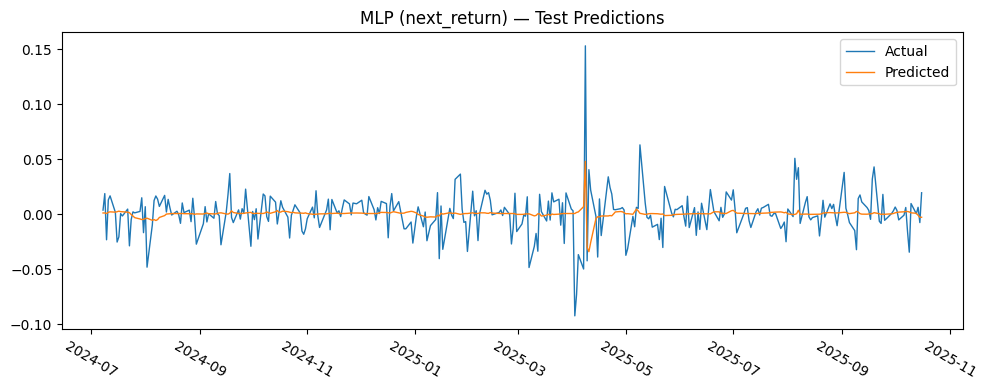

In [181]:
print(f"\nTest MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.4f}")
if TARGET_TYPE == "next_return":
    direction_acc = np.mean(np.sign(y_test) == np.sign(y_pred))
    print(f"Directional accuracy: {direction_acc:.3f}")

plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test, label="Actual", linewidth=1)
plt.plot(dates_test, y_pred, label="Predicted", linewidth=1)
plt.title(f"MLP ({TARGET_TYPE}) — Test Predictions")
plt.xticks(rotation=-30)
plt.legend()
plt.tight_layout()
plt.show()

#model.save("mlp_model_tf.h5")